In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import glob
import pickle
from tqdm import tqdm 
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


In [2]:
# Load the model architecture
model = load_model("model_architecture.h5")

# Load the weights
model.load_weights('spore_test_dec5.hdf5')



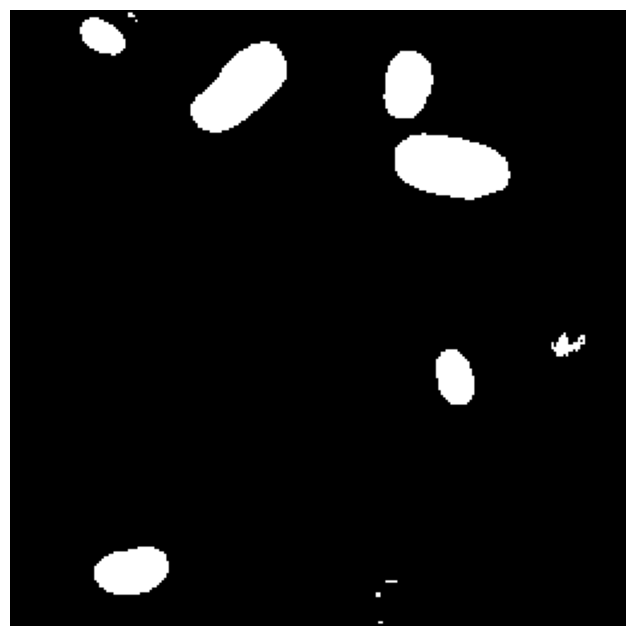

In [3]:
# Load the test image
test_img_other = cv2.imread('Image/1.jpg', 0)
t_img_other = np.expand_dims(test_img_other, axis=-1)
t_img_other = np.expand_dims(t_img_other, 0)

# Make a prediction
prediction_other = (model.predict(t_img_other)[0, :, :, 0] > 0.5).astype(np.uint8)

# Plot and save the prediction
plt.figure(figsize=(8, 8))
#plt.title('Prediction of Test Image')
plt.imshow(prediction_other, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.savefig('Results/1.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()